In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [16]:
data_results = pd.read_csv("https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-24/refs/heads/master/2024_US_County_Level_Presidential_Results.csv", dtype={'county_fips': str})

In [17]:
data_results.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Alabama,01001,Autauga County,20484,7439,28190,13045.0,0.726641,0.263888,0.462753
1,Alabama,01003,Baldwin County,95798,24934,121808,70864.0,0.786467,0.204699,0.581768
2,Alabama,01005,Barbour County,5606,4158,9832,1448.0,0.570179,0.422905,0.147274
3,Alabama,01007,Bibb County,7572,1619,9241,5953.0,0.819392,0.175197,0.644194
4,Alabama,01009,Blount County,25354,2576,28115,22778.0,0.901796,0.091624,0.810173


In [18]:
# Due to duplicate county names and differenes in spelling, we identify counties by fips code
data_results.set_index('county_fips', inplace=True)
# We further need to 

In [19]:
# To simplify the analysis, we focus on the two-party vote, ignoring third-party candidates
data_results['Trump'] = data_results['votes_gop'] / (data_results['votes_gop'] + data_results['votes_dem'])
data_results['Harris'] = data_results['votes_dem'] / (data_results['votes_gop'] + data_results['votes_dem'])


In [20]:
data_results.head()

,state_name,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,Trump,Harris
county_fips,,,,,,,,,,,
01001,Alabama,Autauga County,20484,7439,28190,13045.0,0.726641,0.263888,0.462753,0.733589,0.266411
01003,Alabama,Baldwin County,95798,24934,121808,70864.0,0.786467,0.204699,0.581768,0.793476,0.206524
01005,Alabama,Barbour County,5606,4158,9832,1448.0,0.570179,0.422905,0.147274,0.574150,0.425850
01007,Alabama,Bibb County,7572,1619,9241,5953.0,0.819392,0.175197,0.644194,0.823849,0.176151
01009,Alabama,Blount County,25354,2576,28115,22778.0,0.901796,0.091624,0.810173,0.907769,0.092231


In [21]:
# Now we are going to import the relevant Census data, obtained via the Census API https://www.census.gov/data/developers/data-sets.html
# Since this requires username & password, the dataset was produced using a different script but the data are saved as census_data_2024_final.pkl

data_census = pd.read_pickle("census_data_2024_final.pkl")

In [22]:
data_census.head()

,county_name,population,state,county,household_income_median,race_pct_black,race_pct_native,race_pct_white,race_pct_asian,race_pct_other,...,pct_pop_under_18,pct_pop_age_18_to_29,pct_pop_age_30_to_44,pct_pop_age_45_to_59,pct_pop_age_60_over,household_income_mean,workers_wo_health_ins,pct_hh_publ_assist_food_stamps,pct_retirement,religious
fips,,,,,,,,,,,,,,,,,,,,,
01001,Autauga,58761,AL,001,68315,0.195640,0.001004,0.744490,0.011198,0.047668,...,0.234271,0.145232,0.197784,0.206957,0.215755,90372.476242,0.068425,0.096737,0.268020,0.514395
01003,Baldwin,233420,AL,003,71039,0.083305,0.003766,0.839680,0.008765,0.064485,...,0.211619,0.126335,0.177453,0.196217,0.288377,96026.809982,0.106099,0.077796,0.295258,0.536535
01005,Barbour,24877,AL,005,39712,0.469028,0.003095,0.454597,0.005065,0.068216,...,0.207059,0.150380,0.192105,0.185473,0.264984,60127.506655,0.124154,0.241238,0.217391,0.687071
01007,Bibb,22251,AL,007,50669,0.206867,0.000944,0.758258,0.003101,0.030830,...,0.211901,0.148308,0.208081,0.197834,0.233877,65131.097561,0.068060,0.209673,0.277439,0.488360
01009,Blount,59077,AL,009,57440,0.012340,0.005823,0.913063,0.001693,0.067082,...,0.229599,0.141781,0.177142,0.201026,0.250453,75953.745492,0.103867,0.116758,0.259734,0.573190


In [ ]:
# We will remove some superfluous variables
data_census.drop(columns=['state', 'county', 'county_name'], inplace=True)
census_cols = data_census.columns.to_list()

In [49]:
# One variable that would be very useful to have is the unemployment rate by county, 
# which is not included in the Census data but can be found here: https://www.bls.gov/lau/tables.htm
data_urate = pd.read_excel("laucntycur14.xlsx", skiprows=2, dtype={'State FIPS Code': str, 'County FIPS Code': str})
data_urate = data_urate[data_urate['Period'] == 'Oct-24']
data_urate['fips'] = data_urate['State FIPS Code'] + data_urate['County FIPS Code']
data_urate.set_index('fips', inplace=True)
data_urate = data_urate.rename(columns={'Unemploy-ment Rate (%)': 'urate'})

In [50]:
data_urate.head()

,LAUS Code,State FIPS Code,County FIPS Code,County Name/State Abbreviation,Period,Labor Force,Employed,Unemployed,urate
fips,,,,,,,,,
01001,CN0100100000000,01,001,"Autauga County, AL",Oct-24,28609.0,27798.0,811.0,2.8
01003,CN0100300000000,01,003,"Baldwin County, AL",Oct-24,117918.0,114611.0,3307.0,2.8
01005,CN0100500000000,01,005,"Barbour County, AL",Oct-24,8825.0,8451.0,374.0,4.2
01007,CN0100700000000,01,007,"Bibb County, AL",Oct-24,8727.0,8447.0,280.0,3.2
01009,CN0100900000000,01,009,"Blount County, AL",Oct-24,27134.0,26401.0,733.0,2.7


In [64]:
# We will now merge the three dataframes & remove the counties with missing data
data = pd.concat([data_results, data_census.astype(float), data_urate['urate'].astype(float)], axis=1).dropna(how='any')

In [84]:
# We can now try to predict the votes for Trump vs Harris via the census variables
# cols = census_cols + ['urate']
xgb = XGBRegressor()
xgb.fit(X=data[cols], y=data['Trump'])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: >

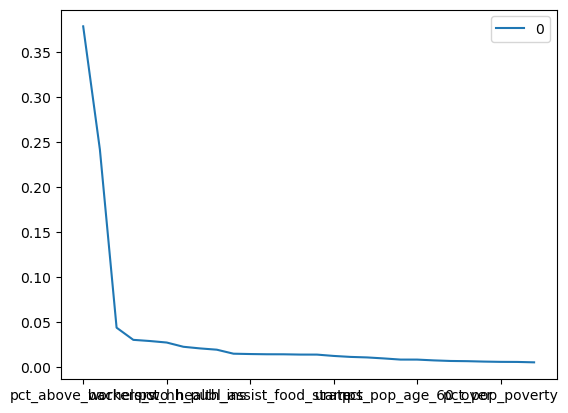

In [77]:
pd.DataFrame(index=xgb.feature_names_in_, data=xgb.feature_importances_).sort_values(by=0, ascending=False).plot()


In [87]:
# We find that explanatory factors become much less potent below the ~0.05 threshold, so we cut off our variables just a little below 5%
expl_variables = pd.DataFrame(index=xgb.feature_names_in_, data=xgb.feature_importances_).sort_values(by=0, ascending=False)
expl_variables = expl_variables[expl_variables[0] >= 0.025].index.to_list()
expl_variables

['pct_above_bachelors',
 'race_pct_white',
 'pct_bachelors_and_above',
 'race_pct_asian',
 'population',
 'workers_wo_health_ins']

In [ ]:
# Now training the model with only the important explanatory variables
xgb = XGBRegressor()
xgb.fit(X=data[expl_variables], y=data['Trump'])
y_pred = xgb.predict(data[expl_variables])

rmse = mean_squared_error(y_pred, data['Trump']) ** 1/2
rmse

0.00030940973356686656

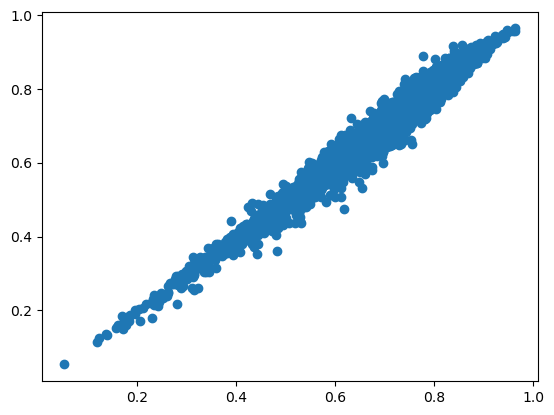

In [ ]:
# We obtain a decent fit for our model
plt.scatter(x=y_pred, y=data['Trump'])